In [1]:
# Installing needed libraires
# pip install scikit-image
# pip install argparse
# pip install matplotlib
# pip install opencv-python
# pip install imutils
# pip install seaborn

# 1. CALCULATING AREA OF EACH GRAIN IN AN IMAGE

Applying Watershed algorithm

In [3]:
import cv2
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
from scipy import ndimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import imutils
warnings.filterwarnings("ignore")

def disp_image(path,x=30,y=7):
    img = cv2.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)
    
def image_area(input_file_path,output_file_path,result_info = False,result_print =False):
    # loading image
    image = cv2.imread(input_file_path)
    shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
    
    # thersholding and greyscaling
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    
    # noise_removal
    kernel = np.ones((3,3),np.uint8)
    noise_removed = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel, iterations=2)
    
    # compute the exact Euclidean distance from every binary
    # pixel to the nearest zero pixel, then find peaks in this
    # distance map
    D = ndimage.distance_transform_edt(noise_removed)
    localMax = peak_local_max(D,indices=False, min_distance=20,labels=thresh)

    # perform a connected component analysis on the local peaks,
    # using 8-connectivity, then appy the Watershed algorithm
    
    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=thresh)
    
    total_g = []
    area_broken_g = []
    for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
        if label == 0:
            continue
        # otherwise, allocate memory for the label region and draw
        # it on the mask
        mask = np.zeros(gray.shape, dtype="uint8")
        mask[labels == label] = 255

        #detect contours in the mask and grab the largest one
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)
        
        contours,h = cnts
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # draw a circle enclosing the object
        ((x, y), r) = cv2.minEnclosingCircle(c)
        
        # cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
        cv2.drawContours(image,contours,-1,(0, 255, 0),2)
        cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0,255),2)
        
        # using threshold to calculate area
        # area_threshold = 1497
        for x in contours:
            area = cv2.contourArea(x)
            total_g.append(area)
    
    cv2.imwrite(output_file_path,image)
    
    area_avg = np.average(total_g)
    result = {'total_grains':len(total_g),
             'grain_area_list' : total_g }
    
    if result_info == True:
        return result

# 2. LOADING THE AREA VALUES INTO DATAFRAME

In [3]:
train_img_name = os.listdir('data/train')
test_img_name = os.listdir('data/test')

In [4]:
train_img_name

['broken_grain_1.jpg',
 'broken_grain_2.jpg',
 'broken_grain_3.jpg',
 'full_grain_1.jpg',
 'full_grain_2.jpg',
 'full_grain_3.jpg',
 'full_grain_4.jpg',
 'full_grain_5.jpg',
 'full_grain_6.jpg',
 'mixed_grains_3.jpg',
 'mixed_grain_1.jpg',
 'mixed_grain_2.jpg']

In [5]:
test_img_name

['image_1.jpg', 'image_2.jpg', 'image_3.jpg', 'image_4.jpg', 'image_5.jpg']

# for folder creation, if already exists it will be passed

In [6]:
try:
    for i in ['data/train_solved','data/test_solved']:
        os.makedirs(i)
except:
    pass

In [7]:
# creating a data frame to store the output of watershed and contour method results

df_train = pd.DataFrame(columns = ['name','total_grains','grain_area_list'])

In [8]:
# finding areas of rice grains through watershed algorithm

In [9]:
for i in train_img_name:
    ip_path = f'data/train/{i}'
    op_path = f'data/train_solved/image_area_{i}'
    result = image_area(ip_path,op_path,True)
    result['name'] = i
    df_train = df_train.append(result,ignore_index = True)
print("All training images loaded")

All training images loaded


In [10]:
df_train

,name,total_grains,grain_area_list
0,broken_grain_1.jpg,746,"[862.5, 0.0, 1409.0, 1516.0, 1484.5, 985.5, 11..."
1,broken_grain_2.jpg,559,"[1310.0, 955.5, 753.5, 585.0, 1575.0, 1656.5, ..."
2,broken_grain_3.jpg,1048,"[768.5, 1450.5, 1639.0, 694.5, 1139.0, 1893.0,..."
3,full_grain_1.jpg,329,"[1230.0, 1295.5, 1322.5, 965.0, 1163.5, 2370.5..."
4,full_grain_2.jpg,552,"[512.0, 649.5, 635.0, 810.0, 831.5, 807.0, 173..."
5,full_grain_3.jpg,717,"[1190.0, 2199.5, 1707.0, 746.5, 1827.0, 1015.5..."
6,full_grain_4.jpg,583,"[2570.0, 1852.5, 1008.0, 1051.5, 2187.5, 4286...."
7,full_grain_5.jpg,718,"[5616.5, 2250.0, 0.0, 430.5, 2420.0, 181.0, 19..."
8,full_grain_6.jpg,726,"[341.5, 4873.0, 0.0, 4068.5, 1279.5, 1090.5, 1..."
9,mixed_grains_3.jpg,737,"[1155.0, 717.5, 1615.5, 1619.5, 3008.0, 3307.5..."


In [11]:
# creating a data frame to store the output of watershed and contour method results
df_test = pd.DataFrame(columns = ['name','total_grains','grain_area_list'])

In [12]:
# finding areas of rice grains through contour and watershed algorithm

In [13]:
for i in test_img_name:
    ip_path = f'data/test/{i}'
    op_path = f'data/test_solved/image_area_{i}'
    result = image_area(ip_path,op_path,True)
    result['name'] = i
    df_test = df_test.append(result,ignore_index = True)
print("All testing images loaded")

All testing images loaded


In [14]:
df_test

,name,total_grains,grain_area_list
0,image_1.jpg,630,"[1175.0, 1146.5, 977.5, 590.0, 664.0, 389.5, 1..."
1,image_2.jpg,645,"[574.5, 2111.5, 1302.0, 2574.0, 1676.5, 784.0,..."
2,image_3.jpg,634,"[886.5, 1295.5, 1387.0, 2395.0, 4560.5, 819.0,..."
3,image_4.jpg,723,"[1389.0, 1499.5, 744.0, 733.0, 1045.5, 1101.5,..."
4,image_5.jpg,737,"[1155.0, 717.5, 1615.5, 1619.5, 3008.0, 3307.5..."


### This step was added to store the result of Step1 and Step 2 as above steps take some time

In [15]:
df_train.to_json(r'.\data\area_train.json',orient = 'records',index=True)
df_test.to_json(r'.\data\area_test.json',orient = 'records',index=True)

# 3. LABELLING THE AVAILABLE DATA AS FULL AND BROKEN

In [16]:
df_train = pd.read_json(r'.\data\area_train.json')
df_test = pd.read_json(r'.\data\area_test.json')

In [17]:
df_train

,name,total_grains,grain_area_list
0,broken_grain_1.jpg,746,"[862.5, 0.0, 1409.0, 1516.0, 1484.5, 985.5, 11..."
1,broken_grain_2.jpg,559,"[1310.0, 955.5, 753.5, 585.0, 1575.0, 1656.5, ..."
2,broken_grain_3.jpg,1048,"[768.5, 1450.5, 1639.0, 694.5, 1139.0, 1893.0,..."
3,full_grain_1.jpg,329,"[1230.0, 1295.5, 1322.5, 965.0, 1163.5, 2370.5..."
4,full_grain_2.jpg,552,"[512.0, 649.5, 635.0, 810.0, 831.5, 807.0, 173..."
5,full_grain_3.jpg,717,"[1190.0, 2199.5, 1707.0, 746.5, 1827.0, 1015.5..."
6,full_grain_4.jpg,583,"[2570.0, 1852.5, 1008.0, 1051.5, 2187.5, 4286...."
7,full_grain_5.jpg,718,"[5616.5, 2250.0, 0.0, 430.5, 2420.0, 181.0, 19..."
8,full_grain_6.jpg,726,"[341.5, 4873.0, 0.0, 4068.5, 1279.5, 1090.5, 1..."
9,mixed_grains_3.jpg,737,"[1155.0, 717.5, 1615.5, 1619.5, 3008.0, 3307.5..."


In [18]:
broken_grain = []
full_grain = []
for i in df_train['grain_area_list'].iloc[0:3]:
    broken_grain.extend(i)
for i in df_train['grain_area_list'].iloc[3:9]:
    full_grain.extend(i)

In [19]:
df1 = pd.DataFrame(columns= ['area','rice_type'])
df1['area'] = broken_grain
df1['rice_type'] = 'broken'
df1

,area,rice_type
0,862.5,broken
1,0.0,broken
2,1409.0,broken
3,1516.0,broken
4,1484.5,broken
...,...,...
2348,1201.5,broken
2349,4278.0,broken
2350,0.0,broken
2351,1791.0,broken


In [20]:
df2 = pd.DataFrame(columns= ['area','rice_type'])
df2['area'] = full_grain
df2['rice_type'] = 'full'
df2

,area,rice_type
0,1230.0,full
1,1295.5,full
2,1322.5,full
3,965.0,full
4,1163.5,full
...,...,...
3620,2012.5,full
3621,516.5,full
3622,1841.0,full
3623,164.5,full


In [21]:
label_data = pd.concat([df1,df2],ignore_index = True)

In [22]:
label_data.to_csv(r'.\data\label_data.csv')

In [23]:
label_data

,area,rice_type
0,862.5,broken
1,0.0,broken
2,1409.0,broken
3,1516.0,broken
4,1484.5,broken
...,...,...
5973,2012.5,full
5974,516.5,full
5975,1841.0,full
5976,164.5,full


In [24]:
df_train

,name,total_grains,grain_area_list
0,broken_grain_1.jpg,746,"[862.5, 0.0, 1409.0, 1516.0, 1484.5, 985.5, 11..."
1,broken_grain_2.jpg,559,"[1310.0, 955.5, 753.5, 585.0, 1575.0, 1656.5, ..."
2,broken_grain_3.jpg,1048,"[768.5, 1450.5, 1639.0, 694.5, 1139.0, 1893.0,..."
3,full_grain_1.jpg,329,"[1230.0, 1295.5, 1322.5, 965.0, 1163.5, 2370.5..."
4,full_grain_2.jpg,552,"[512.0, 649.5, 635.0, 810.0, 831.5, 807.0, 173..."
5,full_grain_3.jpg,717,"[1190.0, 2199.5, 1707.0, 746.5, 1827.0, 1015.5..."
6,full_grain_4.jpg,583,"[2570.0, 1852.5, 1008.0, 1051.5, 2187.5, 4286...."
7,full_grain_5.jpg,718,"[5616.5, 2250.0, 0.0, 430.5, 2420.0, 181.0, 19..."
8,full_grain_6.jpg,726,"[341.5, 4873.0, 0.0, 4068.5, 1279.5, 1090.5, 1..."
9,mixed_grains_3.jpg,737,"[1155.0, 717.5, 1615.5, 1619.5, 3008.0, 3307.5..."


In [25]:
df_test

,name,total_grains,grain_area_list
0,image_1.jpg,630,"[1175.0, 1146.5, 977.5, 590.0, 664.0, 389.5, 1..."
1,image_2.jpg,645,"[574.5, 2111.5, 1302.0, 2574.0, 1676.5, 784.0,..."
2,image_3.jpg,634,"[886.5, 1295.5, 1387.0, 2395.0, 4560.5, 819.0,..."
3,image_4.jpg,723,"[1389.0, 1499.5, 744.0, 733.0, 1045.5, 1101.5,..."
4,image_5.jpg,737,"[1155.0, 717.5, 1615.5, 1619.5, 3008.0, 3307.5..."


# for folder creation, if already exists it will be passed

In [26]:
try:
    for i in ['data/AreaTrain','data/AreaTest']:
        os.makedirs(i)
except:
    pass


In [27]:
for i in range(len(df_train)):
    df_n = pd.DataFrame(columns= ['area'])
    df_n['area'] = df_train.iloc[i,2]
    df_n.to_csv(f'.\data\AreaTrain\image{i+1}_area.csv')
for i in range(len(df_test)):
    df_n = pd.DataFrame(columns= ['area'])
    df_n['area'] = df_test.iloc[i,2]
    df_n.to_csv(f'.\data\AreaTest\image{i+1}_area.csv')

In [4]:
combined = pd.read_csv(r'.\data\label_data.csv',index_col=0)
combined

,area,rice_type
0,862.5,broken
1,0.0,broken
2,1409.0,broken
3,1516.0,broken
4,1484.5,broken
...,...,...
5973,2012.5,full
5974,516.5,full
5975,1841.0,full
5976,164.5,full


In [5]:
combined['rice_type'].value_counts()

full      3625
broken    2353
Name: rice_type, dtype: int64

# 4. VISUALIZING THE DISTRIBUTIONS OF THE DATA

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

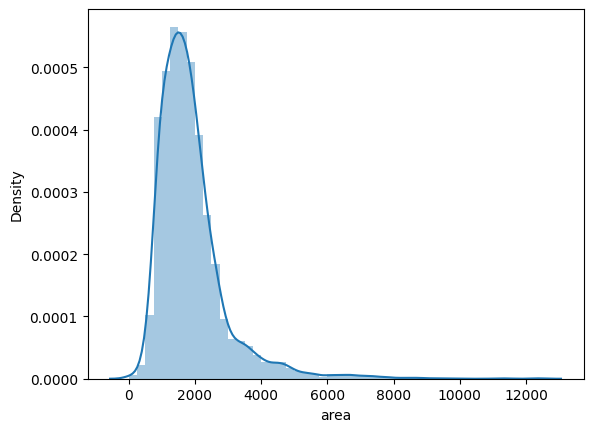

In [7]:
sns.distplot(combined.area)
plt.show()

In [8]:
combined.area.describe()

count     5978.000000
mean      1887.275259
std       1070.297480
min          0.000000
25%       1228.500000
50%       1667.750000
75%       2203.500000
max      12490.000000
Name: area, dtype: float64

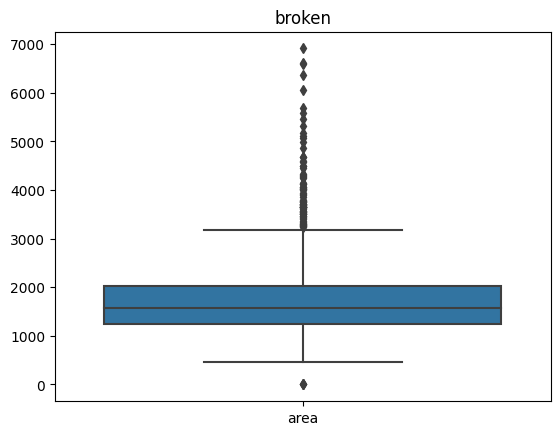

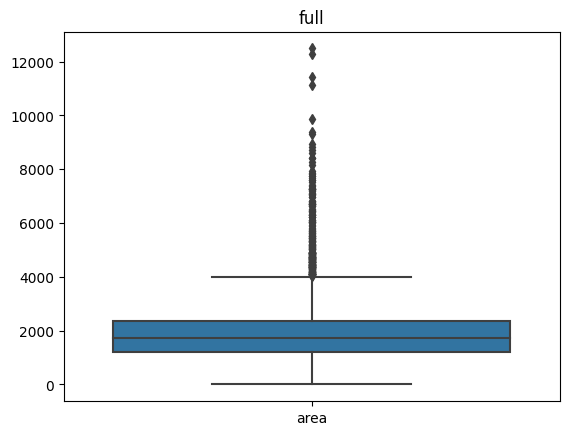

In [32]:
for i in ["broken","full"]:
    sns.boxplot(combined[combined.rice_type == i] )
    plt.title(i)
    plt.show()

In [33]:
# there are outliers in both broken and full rice grain, we will be clipping them to 25 and 75 percentile's
df1.sort_values(by="area",inplace=True)
df2.sort_values(by="area",inplace=True)

# 5. OUTLIER HANDLING

In [34]:
q3 = df1["area"].quantile(0.75)
q1 = df1["area"].quantile(0.25)
iqr = q3-q1
ut = q3+(1.5*iqr)
lt = q1-(1.5*iqr)
df1["area"] = df1["area"].clip(lt,ut)

q3 = df1["area"].quantile(0.75)
q1 = df1["area"].quantile(0.25)
iqr = q3-q1
ut = q3+(1.5*iqr)
lt = q1-(1.5*iqr)
df2["area"] = df2["area"].clip(lt,ut)

<AxesSubplot: >

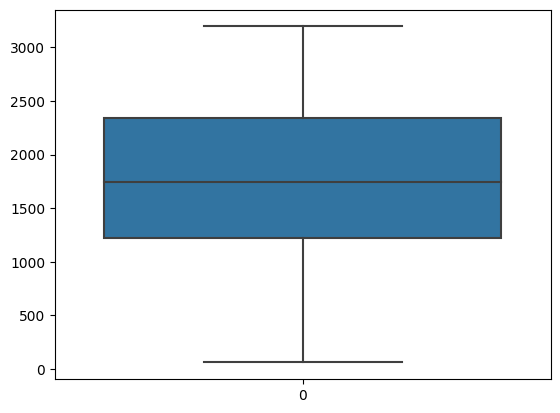

In [35]:
sns.boxplot(df2.area )

In [36]:
combined = pd.concat([df1,df2],ignore_index = True)

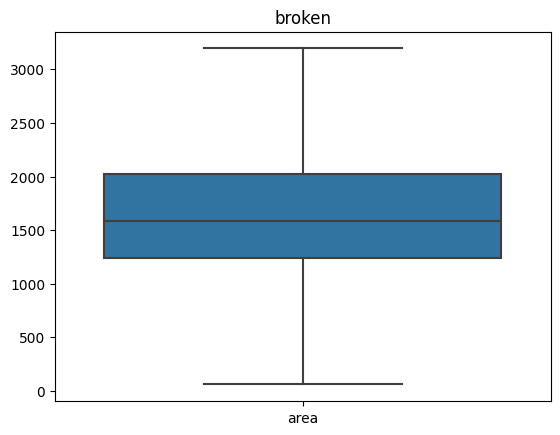

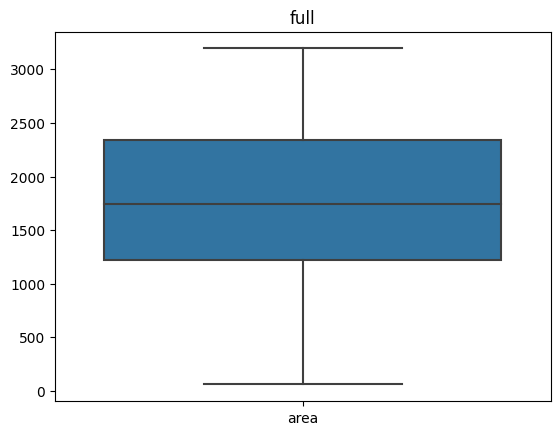

In [37]:
for i in ["broken","full"]:
    sns.boxplot(combined[combined.rice_type == i] )
    plt.title(i)
    plt.show()

In [38]:
combined

,area,rice_type
0,60.25,broken
1,60.25,broken
2,60.25,broken
3,454.00,broken
4,497.00,broken
...,...,...
5973,3194.25,full
5974,3194.25,full
5975,3194.25,full
5976,3194.25,full


# 6. LABEL ENCODING THE CATEGOERICAL DATA

In [39]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
le = LabelEncoder()

# Encode the train target variable
# Fit the label encoder to the target variable
# 0 - broken, 1- full
combined.rice_type = le.fit_transform(combined.rice_type)
combined

,area,rice_type
0,60.25,0
1,60.25,0
2,60.25,0
3,454.00,0
4,497.00,0
...,...,...
5973,3194.25,1
5974,3194.25,1
5975,3194.25,1
5976,3194.25,1


In [40]:
X = np.array(combined.area).reshape(-1,1)
y = combined.rice_type
X

array([[  60.25],
       [  60.25],
       [  60.25],
       ...,
       [3194.25],
       [3194.25],
       [3194.25]])

# 7. MODEL BUILDING
  
 Applying Decision tree, Random forest algorithms

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score,f1_score
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2)

## Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

# Define the hyperparameter search space
param_dist = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2']
}

# Create a logistic regression object
lr = LogisticRegression()

# Create a randomized search object with 10-fold cross-validation
lr_random_search = RandomizedSearchCV(lr, param_distributions=param_dist, n_iter=10, cv=10)

# Fit the randomized search object to the data
lr_random_search.fit(X_train, y_train)

# Get the best hyperparameters and the best score
lr_best_model = lr_random_search.best_estimator_

y_pred = lr_best_model.predict(X_test)

lr_f1score = f1_score(y_test, y_pred)

print(f"F1-Score of Logistic Regression classifier is: {lr_f1score}")

F1-Score of Logistic Regression classifier is: 0.7443569553805774


## KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN classifier object
knn = KNeighborsClassifier()

# Define the hyperparameters to tune and their possible values
param_dist = {'n_neighbors': np.arange(1, 50),
              'metric': ['euclidean', 'manhattan', 'cosine'],
              'weights': ['uniform', 'distance']}

# Number of random combinations to try
n_iter = 100

# Perform randomized search using 10-fold cross-validation
knn_random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=n_iter, cv=10)
knn_random_search.fit(X_train, y_train)

# Get the best hyperparameters and the best score
knn_best_model = knn_random_search.best_estimator_

y_pred = knn_best_model.predict(X_test)

knn_f1score = f1_score(y_test, y_pred)

print(f"F1-Score of KNN classifier is: {knn_f1score}")

F1-Score of KNN classifier is: 0.7443569553805774


## Decision Tree with hyper parameter tuning

In [44]:
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree classifier object
dt = DecisionTreeClassifier()

# Define the parameter grid to search
param_grid = {'max_depth': range(1,100),
              'min_samples_split': range(1,100),
              'min_samples_leaf': range(1,100)}

auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)

# Initialize the RandomizedSearchCV object
dt_random_search = RandomizedSearchCV(dt, param_distributions=param_grid, cv=10, n_jobs=-1, scoring=auc_scorer)

# Fit the RandomizedSearchCV object to the training data
dt_random_search.fit(X_train, y_train)

# Get the best model with best parameters
dt_best_model = dt_random_search.best_estimator_

y_pred = dt_best_model.predict(X_test)

dt_f1score = f1_score(y_test, y_pred)

print(f"F1-Score of Decision Tree classifier is: {dt_f1score}")

F1-Score of Decision Tree classifier is: 0.6773162939297124


## Random Forest with hyper parameter tuning

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid to search
param_dist = {'n_estimators': [10,50,200],
              'max_depth': range(1,100),
              'min_samples_split': range(1,100),
              'min_samples_leaf': range(1,100),
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion': ['gini', 'entropy'],
              'bootstrap': [True],
              'oob_score': [True, False],
              'verbose': [0, 1],
              'random_state': [42],
              'n_jobs': [-1]
             }

# Initialize the RandomForestClassifier 
rf = RandomForestClassifier()

auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
# Initialize the RandomizedSearchCV object
rf_random_search = RandomizedSearchCV(rf, param_distributions=param_dist, cv=5, n_jobs=-1, scoring=auc_scorer,refit = True)

# Fit the RandomizedSearchCV object to the training data
rf_random_search.fit(X_train, y_train)

# Get the best model with best parameters
rf_best_model = rf_random_search.best_estimator_

y_pred = rf_best_model.predict(X_test)

rf_f1score = f1_score(y_test, y_pred)

print(f"F1-Score of Random forest classifier is: {rf_f1score}")

F1-Score of Random forest classifier is: 0.7085577498503891


In [46]:
max(lr_f1score,knn_f1score,dt_f1score,rf_f1score)

0.7443569553805774

## The best model for above algorithms is logistic regression. But when tested the model for prediction it is not able predict false positives well, and Random forest is doing well in this scenario.
## So Random Forest is used for classification of rice grains

In [47]:
best_model = rf_best_model

test = os.listdir('data/test')
train = os.listdir('data/train')
area_train = os.listdir('data/AreaTrain')
area_test = os.listdir('data/AreaTest')

# 8. Counting no. of full / broken grains in each image

In [48]:
dir1 = test
dir2 = area_test
result_df = pd.DataFrame(columns = ['file_name','total_rice_grain','total_broken_rice_grain'])
for i in range(len(dir1)):
    image_area = pd.read_csv(f'data/AreaTest/{dir2[i]}',index_col = 0)
    pred = best_model.predict(image_area['area'].values.reshape(-1,1))
    x = pd.DataFrame(pred).value_counts()
    x = {'total_broken_rice_grain': x[0]}
    x['file_name'] = dir1[i]
    x['total_rice_grain'] = image_area['area'].size
    result_df = result_df.append(x,ignore_index = True)

In [49]:
result_df

,file_name,total_rice_grain,total_broken_rice_grain
0,image_1.jpg,630,110
1,image_2.jpg,645,111
2,image_3.jpg,634,131
3,image_4.jpg,723,168
4,image_5.jpg,737,101


# 9.Saving the result as submission.csv

In [51]:
result_df.to_csv('submission.csv',index = False)